In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('MsPacman-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

print(torch.cuda.is_available())
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

False


In [3]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
    
class DQN_OPENAI(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN_OPENAI, self).__init__()
        def compute_padding_same(h,w,filters,stride,kernel_size):
            p_w = ((stride-1)*w-stride+filters)//2
            p_h = ((stride-1)*h-stride+filters)//2
            return (p_h,p_w)
        def conv2d_size_out(size, kernel_size=5, stride=2, padding=0):
            return (size + 2 * padding - (kernel_size - 1) - 1) // stride  + 1
        p_1 = compute_padding_same(h,w,filters=32,stride=4,kernel_size=8)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4, padding=p_1)
        h_1, w_1 = conv2d_size_out(h,8,4, p_1[0]), conv2d_size_out(w,8,4, p_1[1])
        p_2 = compute_padding_same(h_1,w_1,filters=64,stride=2,kernel_size=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=p_2)
        h_2, w_2 = conv2d_size_out(h_1,4,2,p_2[0]), conv2d_size_out(w_1,4,2, p_2[1])
        p_3 = compute_padding_same(h_2,w_2,filters=64,stride=1,kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=p_3)
        
        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        w_3 = conv2d_size_out(w_2,3,1,p_3[0])
        h_3 = conv2d_size_out(h_2,3,1,p_3[1])
        linear_input_size = w_3 * h_3 * 64
        self.head = nn.Linear(linear_input_size, outputs)
        
        # Activations
        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()
        self.prelu3 = nn.PReLU()

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.prelu1(self.conv1(x))
        x = self.prelu2(self.conv2(x))
        x = self.prelu3(self.conv3(x))
        return self.head(x.view(x.size(0), -1))

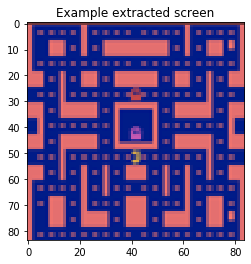

In [4]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize((84,84), interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, :int(screen_height * 0.8),:]

#     view_width = int(screen_width * 0.6)
#     cart_location = get_cart_location(screen_width)
#     if cart_location < view_width // 2:
#         slice_range = slice(view_width)
#     elif cart_location > (screen_width - view_width // 2):
#         slice_range = slice(-view_width, None)
#     else:
#         slice_range = slice(cart_location - view_width // 2,
#                             cart_location + view_width // 2)
#     # Strip off the edges, so that we have a square image centered on a cart
#     screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [5]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 4
MEMORY_SIZE = 1e6
INIT_MEMORY_SIZE = MEMORY_SIZE //20

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

def select_action(policy_net,state):
    return policy_net(state).max(1)[1].view(1, 1)
    

In [9]:
from IPython.display import clear_output
import os


def load_open_ai_model(models_root='models'):
    # image size = (84,84) n_actions=9
    policy_net = DQN_OPENAI(84,84,9).to( device )
    checkpoint = torch.load(os.path.join(models_root,'dqn_openai_rms_last'), map_location=device)
    policy_net.load_state_dict(checkpoint['model_state_dict_policy'])
    return policy_net

def load_small_net(models_root='models'):
    # image size = (84,84) n_actions=9
    policy_net = DQN(84,84,9).to( device )
    checkpoint = torch.load(os.path.join(models_root,'policy_net_2'), map_location=device)
    policy_net.load_state_dict(checkpoint['model_state_dict'])
    return policy_net


def eval_model(policy_net, num_episodes=1):
    rewards = []
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen - last_screen
        tmp_cum_reward = 0
        for t in count():
            action = select_action(policy_net,state)
            _, reward, done, _  = env.step(action.item())
            tmp_cum_reward += reward
            # uncomment below to see episodes
#             plt.figure()
#             img = plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),interpolation='none')
#             plt.title('Example extracted screen')
#             plt.show()
#     #             plt.pause(3)
#             clear_output(wait=True)
            last_screen = current_screen
            current_screen = get_screen()
            if not done:
                state = current_screen - last_screen
            else:
                state = None
        rewards.append(tmp_cum_reward)
    return rewards

### OPEN AI MODEL LOADING

In [10]:
policy_net = load_open_ai_model()

#### OPEN AI EVAL

In [ ]:
eval_model(policy_net)

### SMALL MODEL LOADING

In [ ]:
small_net = load_small_net()

#### SMALL MODEL EVAL

In [31]:
eval_model(small_net)

KeyboardInterrupt: 